# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

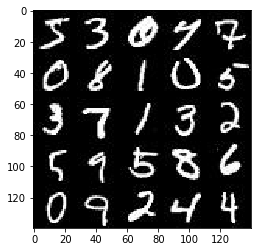

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

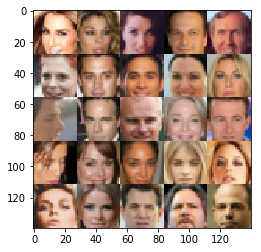

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\Joe\\Anaconda3\\envs\\tensorflow1.3\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\Joe\\Anaconda3\\envs\\tensorflow1.3\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\Joe\\Anaconda3\\envs\\tensorflow1.3\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\Joe\\Anaconda3\\envs\\tensorflow1.3\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\Joe\\Anaconda3\\envs\\tensorflow1.3\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instan

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha* x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        
        flat = tf.reshape( x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [117]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    
    
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 512, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        #x4 = tf.layers.conv2d_transpose(x3, 128, 4, strides=2, padding='valid')
        #x4 = tf.layers.batch_normalization(x4, training=is_train)
        #x4 = tf.maximum(alpha * x4, x4)
        
        x5 = tf.layers.conv2d_transpose(x3, 64, 4, strides=1, padding='same')
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(alpha * x5, x5)

        logits = tf.layers.conv2d_transpose(x5, out_channel_dim, 4, strides=2, padding='same')

        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [118]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(generator_model, reuse=True)
    ce_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels= tf.ones_like(d_model_real))
    ce_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels= tf.zeros_like(d_model_fake))
    ce_g = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels= tf.ones_like(d_model_fake))
    d_loss_real = tf.reduce_mean(ce_real)
    d_loss_fake = tf.reduce_mean(ce_fake) 
    g_loss = tf.reduce_mean(ce_g) 
    return d_loss_real+d_loss_fake, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [119]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainables = tf.trainable_variables()
    disc_vars = [var for var in trainables if var.name.startswith('discriminator')]
    gen_vars = [var for var in trainables if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        gen_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)

    return disc_opt, gen_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [120]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [121]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    sample_z = np.random.uniform(-1., 1., size=(100, z_dim) )
    samples, losses = [],[]
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    disc_opt, gen_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    show_every = 50
    print_every = 10
    #saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1., 1., size=(batch_size, z_dim))
                d_feed_dic = {input_real: batch_images, input_z: batch_z, lr: learning_rate}
                g_feed_dic = {input_z: batch_z, input_real: batch_images, lr: learning_rate}
                _ = sess.run(disc_opt, feed_dict=d_feed_dic)
                _ = sess.run(gen_opt, feed_dict=d_feed_dic)
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess=sess, n_images = 10, input_z = input_z, out_channel_dim = data_shape[3], image_mode = data_image_mode)

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1606... Generator Loss: 9.6522
Epoch 1/2... Discriminator Loss: 0.0670... Generator Loss: 8.9462
Epoch 1/2... Discriminator Loss: 1.9444... Generator Loss: 0.1738
Epoch 1/2... Discriminator Loss: 0.9284... Generator Loss: 2.3061
Epoch 1/2... Discriminator Loss: 2.1578... Generator Loss: 7.5766


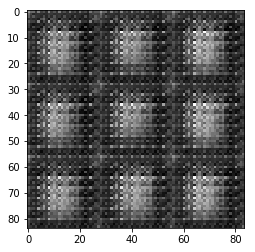

Epoch 1/2... Discriminator Loss: 0.4881... Generator Loss: 3.9234
Epoch 1/2... Discriminator Loss: 0.4834... Generator Loss: 5.9213
Epoch 1/2... Discriminator Loss: 0.2867... Generator Loss: 2.1823
Epoch 1/2... Discriminator Loss: 0.3672... Generator Loss: 1.8574
Epoch 1/2... Discriminator Loss: 0.6329... Generator Loss: 2.2098


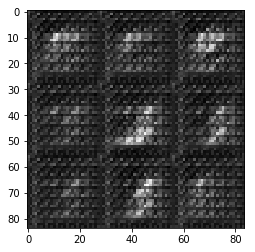

Epoch 1/2... Discriminator Loss: 1.0820... Generator Loss: 1.6648
Epoch 1/2... Discriminator Loss: 0.6301... Generator Loss: 1.3554
Epoch 1/2... Discriminator Loss: 0.9551... Generator Loss: 0.7766
Epoch 1/2... Discriminator Loss: 1.9158... Generator Loss: 5.3269
Epoch 1/2... Discriminator Loss: 0.9974... Generator Loss: 1.1266


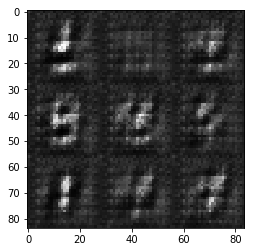

Epoch 1/2... Discriminator Loss: 1.1153... Generator Loss: 1.5277
Epoch 1/2... Discriminator Loss: 0.9299... Generator Loss: 0.7875
Epoch 1/2... Discriminator Loss: 0.8427... Generator Loss: 0.8702
Epoch 1/2... Discriminator Loss: 1.0325... Generator Loss: 0.6479
Epoch 1/2... Discriminator Loss: 1.1425... Generator Loss: 1.7669


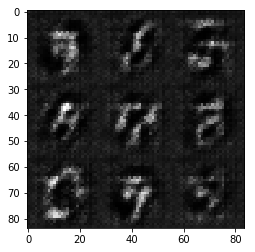

Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 1.4985
Epoch 1/2... Discriminator Loss: 0.9797... Generator Loss: 1.3336
Epoch 1/2... Discriminator Loss: 1.0190... Generator Loss: 1.8667
Epoch 1/2... Discriminator Loss: 0.9994... Generator Loss: 1.4453
Epoch 1/2... Discriminator Loss: 0.9470... Generator Loss: 1.4878


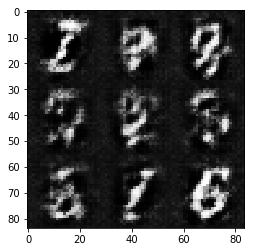

Epoch 1/2... Discriminator Loss: 0.8860... Generator Loss: 0.9635
Epoch 1/2... Discriminator Loss: 1.0725... Generator Loss: 0.6197
Epoch 1/2... Discriminator Loss: 1.0820... Generator Loss: 0.7035
Epoch 1/2... Discriminator Loss: 1.2152... Generator Loss: 0.4938
Epoch 1/2... Discriminator Loss: 0.9258... Generator Loss: 0.7288


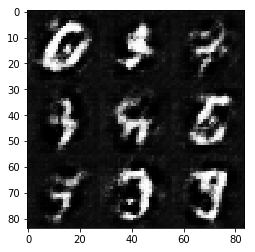

Epoch 1/2... Discriminator Loss: 1.6686... Generator Loss: 0.2607
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.3861
Epoch 1/2... Discriminator Loss: 0.9127... Generator Loss: 0.8843
Epoch 1/2... Discriminator Loss: 1.1996... Generator Loss: 0.6268
Epoch 1/2... Discriminator Loss: 0.8006... Generator Loss: 1.0088


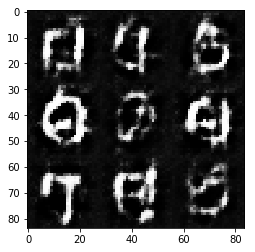

Epoch 1/2... Discriminator Loss: 0.7529... Generator Loss: 1.4709
Epoch 1/2... Discriminator Loss: 0.8897... Generator Loss: 1.8637
Epoch 1/2... Discriminator Loss: 0.7695... Generator Loss: 1.4592
Epoch 1/2... Discriminator Loss: 0.9931... Generator Loss: 0.8252
Epoch 1/2... Discriminator Loss: 1.1644... Generator Loss: 0.5245


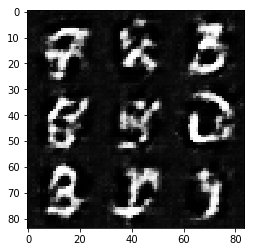

Epoch 1/2... Discriminator Loss: 1.3143... Generator Loss: 2.5590
Epoch 1/2... Discriminator Loss: 0.8578... Generator Loss: 0.8071
Epoch 1/2... Discriminator Loss: 0.8865... Generator Loss: 1.0330
Epoch 1/2... Discriminator Loss: 0.9171... Generator Loss: 1.1367
Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 0.5644


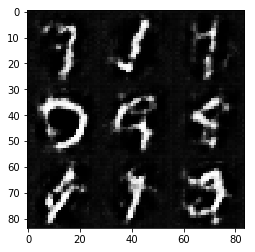

Epoch 1/2... Discriminator Loss: 1.0866... Generator Loss: 1.3996
Epoch 2/2... Discriminator Loss: 0.9480... Generator Loss: 1.0018
Epoch 2/2... Discriminator Loss: 1.1445... Generator Loss: 0.5260
Epoch 2/2... Discriminator Loss: 1.1456... Generator Loss: 0.5015
Epoch 2/2... Discriminator Loss: 1.4068... Generator Loss: 0.3895


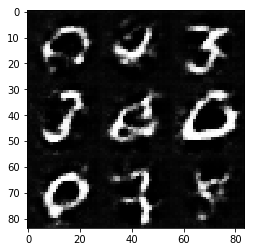

Epoch 2/2... Discriminator Loss: 0.7629... Generator Loss: 1.0061
Epoch 2/2... Discriminator Loss: 0.9277... Generator Loss: 1.0806
Epoch 2/2... Discriminator Loss: 0.9298... Generator Loss: 1.3107
Epoch 2/2... Discriminator Loss: 1.4526... Generator Loss: 0.3384
Epoch 2/2... Discriminator Loss: 1.0914... Generator Loss: 1.2832


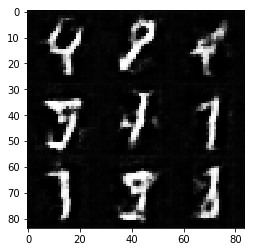

Epoch 2/2... Discriminator Loss: 0.8242... Generator Loss: 1.4686
Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 2.1303
Epoch 2/2... Discriminator Loss: 0.9681... Generator Loss: 1.2153
Epoch 2/2... Discriminator Loss: 1.0488... Generator Loss: 0.9104
Epoch 2/2... Discriminator Loss: 2.0414... Generator Loss: 0.1740


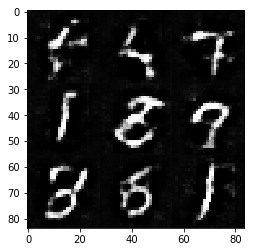

Epoch 2/2... Discriminator Loss: 0.9600... Generator Loss: 0.8775
Epoch 2/2... Discriminator Loss: 0.9199... Generator Loss: 0.9228
Epoch 2/2... Discriminator Loss: 2.1233... Generator Loss: 0.1775
Epoch 2/2... Discriminator Loss: 1.0407... Generator Loss: 0.7080
Epoch 2/2... Discriminator Loss: 0.9465... Generator Loss: 1.0656


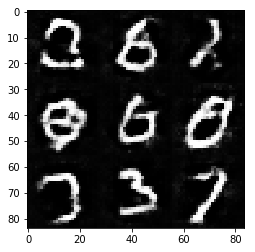

Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 1.2474
Epoch 2/2... Discriminator Loss: 1.0705... Generator Loss: 1.6673
Epoch 2/2... Discriminator Loss: 1.0812... Generator Loss: 1.2151
Epoch 2/2... Discriminator Loss: 0.8537... Generator Loss: 1.3650
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 0.5546


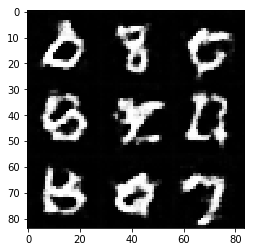

Epoch 2/2... Discriminator Loss: 1.0250... Generator Loss: 0.7943
Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 0.9649
Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 1.6090
Epoch 2/2... Discriminator Loss: 0.9087... Generator Loss: 1.0419
Epoch 2/2... Discriminator Loss: 1.2466... Generator Loss: 0.4684


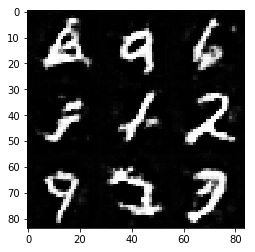

Epoch 2/2... Discriminator Loss: 0.9746... Generator Loss: 0.8131
Epoch 2/2... Discriminator Loss: 1.0306... Generator Loss: 0.6971
Epoch 2/2... Discriminator Loss: 1.0446... Generator Loss: 0.8132
Epoch 2/2... Discriminator Loss: 2.3311... Generator Loss: 2.6647
Epoch 2/2... Discriminator Loss: 1.0481... Generator Loss: 0.9566


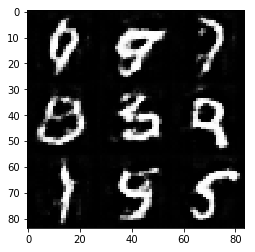

Epoch 2/2... Discriminator Loss: 0.9355... Generator Loss: 0.7713
Epoch 2/2... Discriminator Loss: 2.1526... Generator Loss: 2.7909
Epoch 2/2... Discriminator Loss: 0.8757... Generator Loss: 1.0138
Epoch 2/2... Discriminator Loss: 0.9669... Generator Loss: 0.9189
Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 0.5432


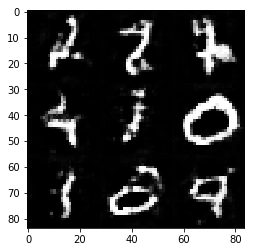

Epoch 2/2... Discriminator Loss: 1.3161... Generator Loss: 0.3931
Epoch 2/2... Discriminator Loss: 0.9906... Generator Loss: 0.8507
Epoch 2/2... Discriminator Loss: 0.9476... Generator Loss: 1.0274
Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 1.0322
Epoch 2/2... Discriminator Loss: 0.9658... Generator Loss: 0.6711


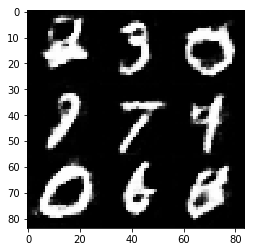

Epoch 2/2... Discriminator Loss: 1.0054... Generator Loss: 1.0813
Epoch 2/2... Discriminator Loss: 1.1224... Generator Loss: 0.8914
Epoch 2/2... Discriminator Loss: 1.0839... Generator Loss: 0.6736


In [127]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.4440
Epoch 1/1... Discriminator Loss: 0.3259... Generator Loss: 10.5886
Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.2790
Epoch 1/1... Discriminator Loss: 0.5111... Generator Loss: 12.0581
Epoch 1/1... Discriminator Loss: 0.6114... Generator Loss: 5.2200


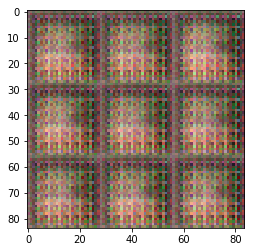

Epoch 1/1... Discriminator Loss: 4.9943... Generator Loss: 0.0082
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 1.7079
Epoch 1/1... Discriminator Loss: 0.5009... Generator Loss: 1.7614
Epoch 1/1... Discriminator Loss: 0.8941... Generator Loss: 4.8220
Epoch 1/1... Discriminator Loss: 0.5496... Generator Loss: 1.3738


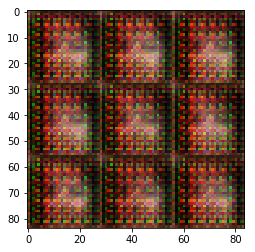

Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 1.8326
Epoch 1/1... Discriminator Loss: 0.1838... Generator Loss: 2.5733
Epoch 1/1... Discriminator Loss: 0.4220... Generator Loss: 1.6610
Epoch 1/1... Discriminator Loss: 0.5063... Generator Loss: 1.5260
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 0.9634


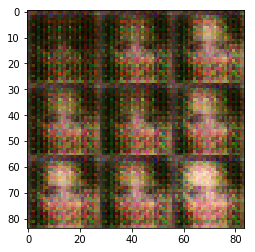

Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 1.2736
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 0.5362... Generator Loss: 1.5090
Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 2.4471


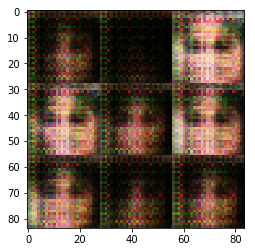

Epoch 1/1... Discriminator Loss: 0.5090... Generator Loss: 1.1647
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 2.2411
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 1.1820
Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 3.9474
Epoch 1/1... Discriminator Loss: 0.6154... Generator Loss: 1.4042


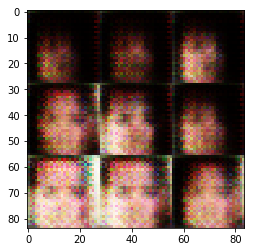

Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 1.7780
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 1.8403
Epoch 1/1... Discriminator Loss: 0.7604... Generator Loss: 1.6701
Epoch 1/1... Discriminator Loss: 0.5961... Generator Loss: 1.5501
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.3241


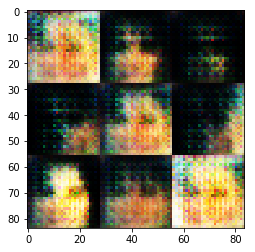

Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.1270
Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 1.8252
Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 2.3035
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 3.1185


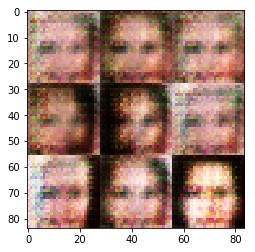

Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 2.4516
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 1.8410


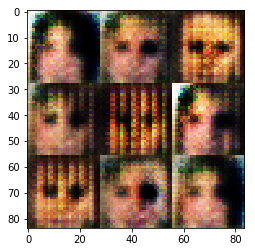

Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.2615
Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 0.7296... Generator Loss: 1.9155
Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 1.7227


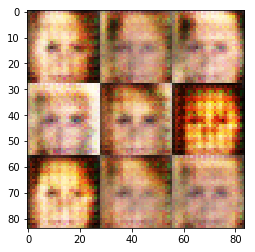

Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.4830
Epoch 1/1... Discriminator Loss: 1.5584... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 1.1727
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 2.3174
Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 0.9540


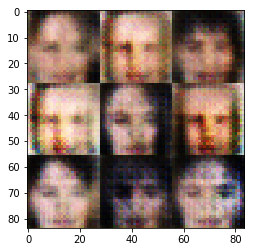

Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.5930... Generator Loss: 0.3437
Epoch 1/1... Discriminator Loss: 0.4905... Generator Loss: 1.7281
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.7816


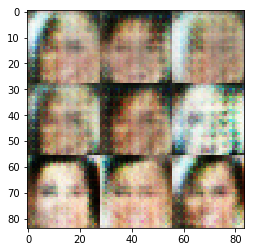

Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 1.5505
Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 1.0020
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 1.5644
Epoch 1/1... Discriminator Loss: 1.7021... Generator Loss: 0.3930
Epoch 1/1... Discriminator Loss: 0.9918... Generator Loss: 1.4416


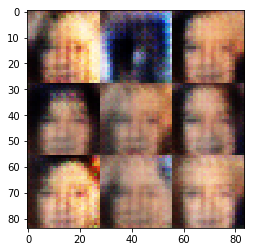

Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 2.1566
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 1.3663
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 1.5536
Epoch 1/1... Discriminator Loss: 0.8513... Generator Loss: 1.7868


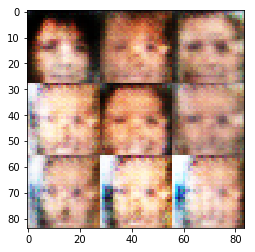

Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 1.4246
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 2.4009
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 1.9947
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 1.5270


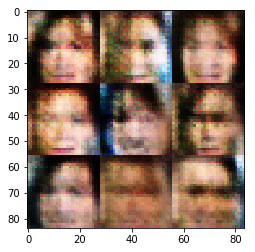

Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.4847
Epoch 1/1... Discriminator Loss: 0.7825... Generator Loss: 1.7428
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 0.8998
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.6982... Generator Loss: 0.3834


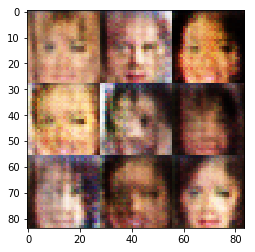

Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 1.2765
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.4564
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.5486


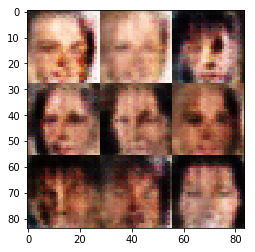

Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 1.7849
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 1.2722
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.2281


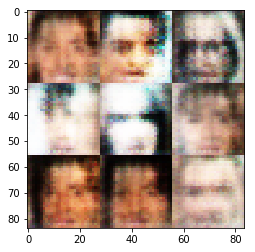

Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 1.2141
Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.4002
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.8008


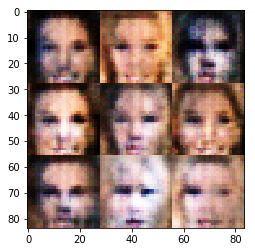

Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 1.2127
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 1.0531
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 1.0466


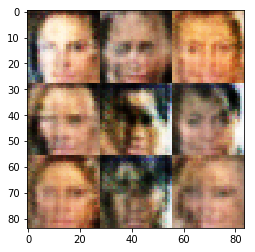

Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.9663
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 1.4746


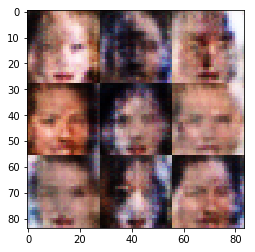

Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 2.3774
Epoch 1/1... Discriminator Loss: 1.5901... Generator Loss: 0.4655
Epoch 1/1... Discriminator Loss: 0.8873... Generator Loss: 1.3429
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.9134
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.4301


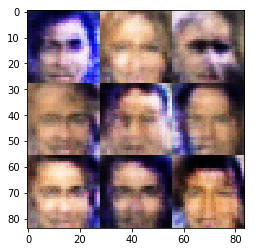

Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.8998
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 1.2310
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.7309


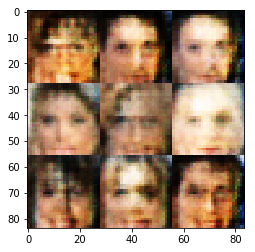

Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 1.1445


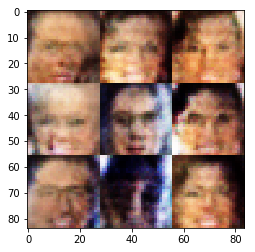

Epoch 1/1... Discriminator Loss: 0.8832... Generator Loss: 1.5884
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.4069
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 1.2088
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 0.7426


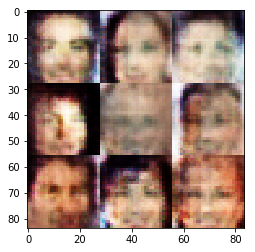

Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.5299
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 1.0153


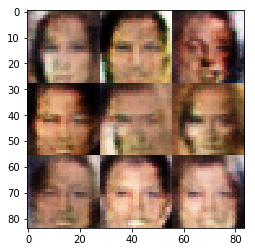

Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 1.1474
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 0.7163


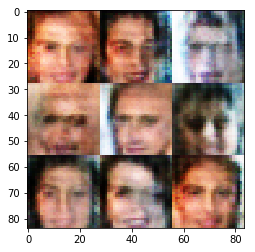

Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 1.1720
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.4222
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 0.8145


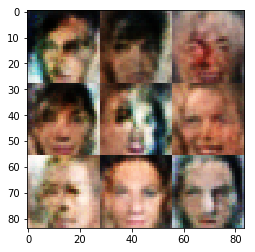

Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 1.3050
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.2186
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 1.0953


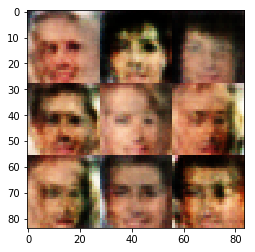

Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.5957


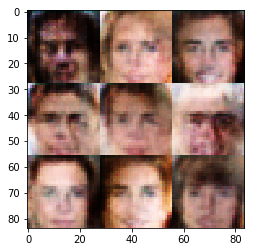

Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 1.4886
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 1.4928
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 0.8535... Generator Loss: 1.0267
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.4390


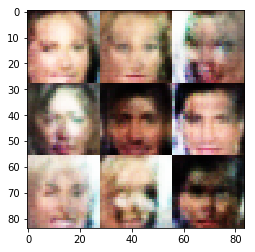

Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 1.3949
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.5505


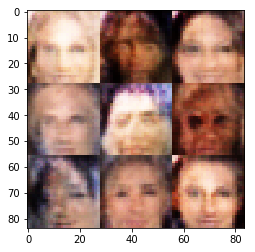

Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 1.5406
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 1.0905
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.4679


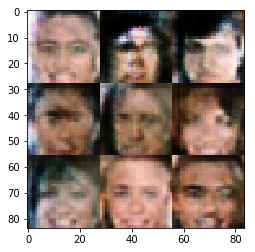

Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 1.2210
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 1.3845
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 1.3883
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.8011


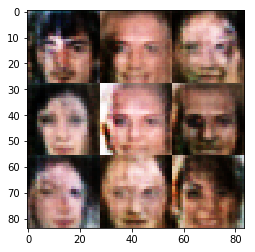

Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 1.1983


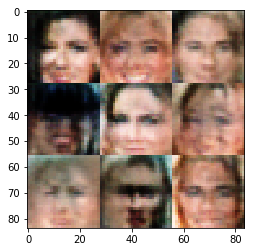

Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 1.2121
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 1.8792
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 1.1544


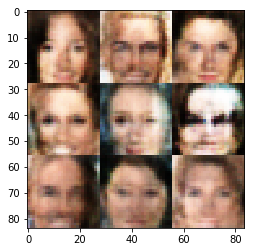

Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 0.8203


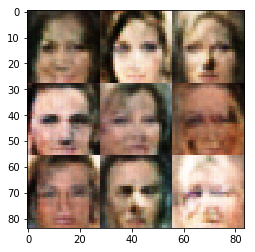

Epoch 1/1... Discriminator Loss: 0.7636... Generator Loss: 1.4187
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 1.1196
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 1.1894
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 0.8417


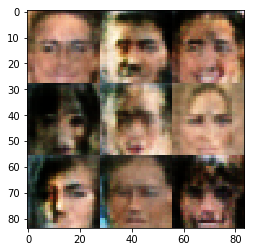

Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.4755
Epoch 1/1... Discriminator Loss: 0.8780... Generator Loss: 1.2041
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 1.1721


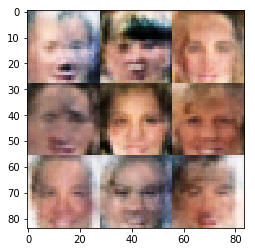

Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 1.6482
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.0607


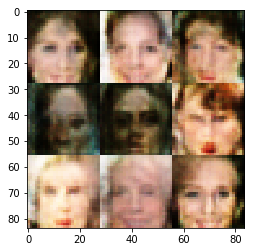

Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 1.2300
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 1.5457
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 1.1065
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.7273


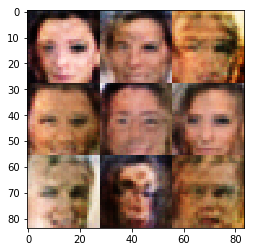

Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.8710


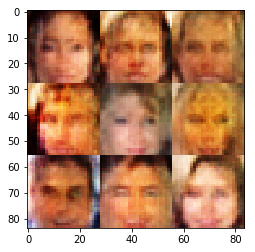

Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.4731
Epoch 1/1... Discriminator Loss: 1.5420... Generator Loss: 0.4130
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.1959


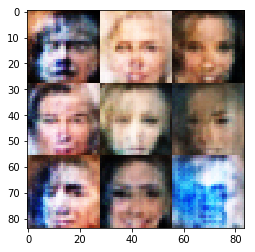

Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.1510
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 1.2675
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.8259


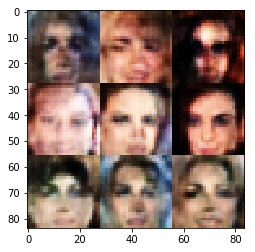

Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 1.4497


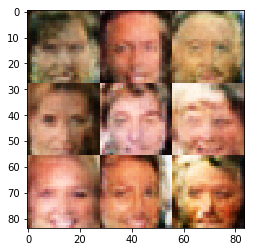

Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.5510
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.7792


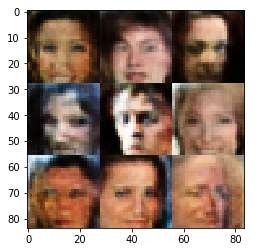

Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.3700
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 1.3083


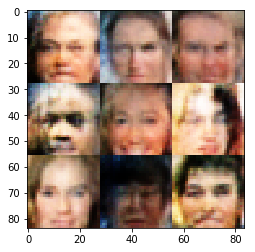

Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 1.1726


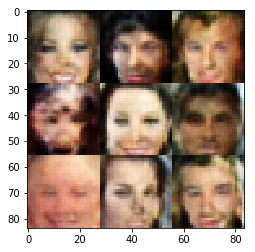

Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.5464
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.7419


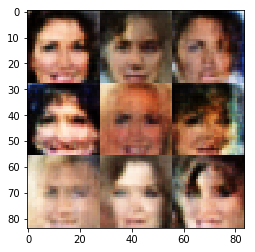

Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 1.3366
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.1478
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 1.4060


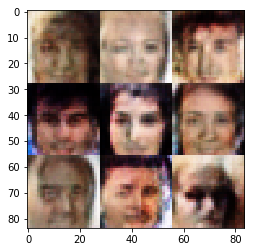

Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 1.0365
Epoch 1/1... Discriminator Loss: 1.5906... Generator Loss: 0.3492


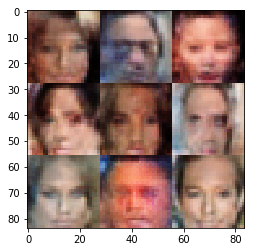

Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 1.6416... Generator Loss: 0.3993


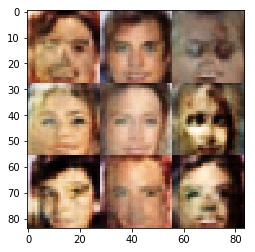

Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.4424
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.7622


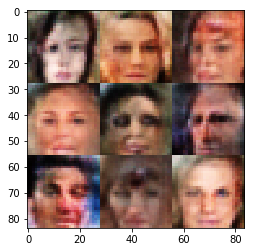

Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.9699
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.7781


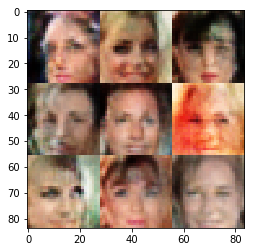

Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.5842
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.4507


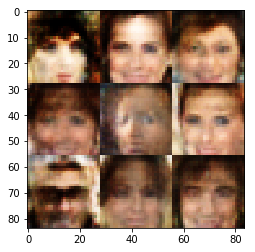

Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.4395
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.4311
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 1.6282
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.7880


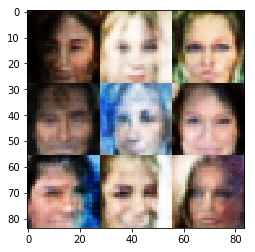

Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 1.0392
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 0.9151
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.8278


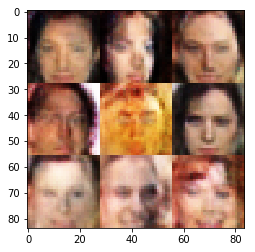

Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 0.8843... Generator Loss: 0.9644


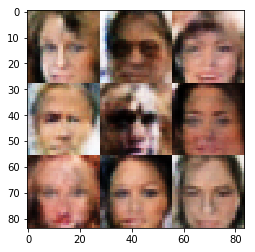

Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 0.9983
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 1.0159
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.8233


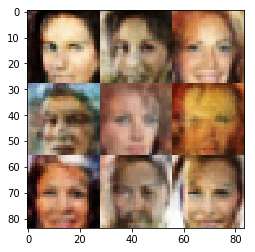

Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 1.1087
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 1.3870
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.6585


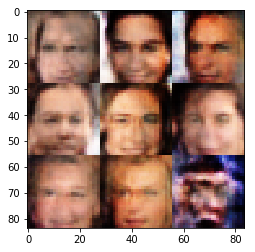

Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 1.1035
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.5645


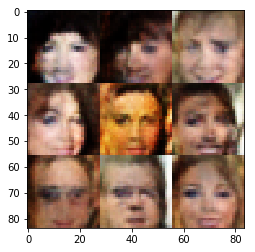

Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.2999
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 1.3920
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.7918


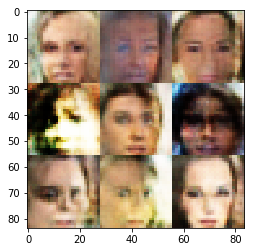

Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 1.5996


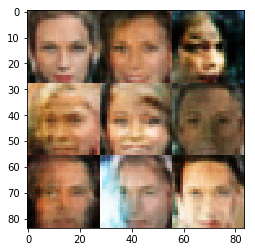

Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.4790
Epoch 1/1... Discriminator Loss: 1.6768... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.9956


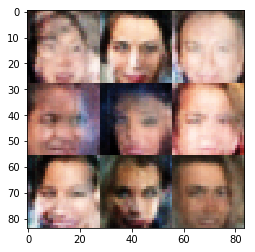

Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 0.8012


In [128]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.